In [24]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import seaborn as sns
import numpy as np
from sklearn.cross_decomposition import PLSRegression

In [ ]:
train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
train.head()

In [ ]:
test.head()

In [ ]:
train = train.drop(['Unnamed: 0', 'id'], axis=1)
train.head()

In [ ]:
test = test.drop(['Unnamed: 0', 'id'], axis=1)
test.head()

In [ ]:
train.columns[train.isna().any()].tolist()

In [ ]:
test.columns[test.isna().any()].tolist()

In [ ]:
def detect_outliers(column):
    threshold = 3
    z_score = (column-column.mean())/column.std()
    return(abs(z_score)>threshold).any()

In [ ]:
numeric_cols_impute = ['Arrival Delay in Minutes']
bool_train_outliers = train[numeric_cols_impute].apply(lambda x: detect_outliers(x.dropna()))
bool_test_outliers = test[numeric_cols_impute].apply(lambda x: detect_outliers(x.dropna()))


In [ ]:
print(f"Train_outliers: \n {bool_train_outliers}")
print(f"Test_outliers:  \n {bool_test_outliers}")

In [ ]:
train[numeric_cols_impute] = train[numeric_cols_impute].apply(lambda x: x.fillna(x.median()))
test[numeric_cols_impute]= test[numeric_cols_impute].apply(lambda x: x.fillna(x.median()))

In [ ]:
train.columns

In [ ]:
columns_of_interest = [
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'Cleanliness'
]

unique_levels = {}

# Iterate through each column of interest and get unique levels
for column in columns_of_interest:
    if column in train.columns:
        unique_levels[column] = train[column].unique()

# Display the unique levels for each column
for column, levels in unique_levels.items():
    print(f"Unique levels for '{column}': {levels}")

In [ ]:
unique_levels = {}

# Iterate through each column of interest and get unique levels
for column in columns_of_interest:
    if column in train.columns:
        unique_levels[column] = test[column].unique()

# Display the unique levels for each column
for column, levels in unique_levels.items():
    print(f"Unique levels for '{column}': {levels}")

In [ ]:
numeric_columns = ['Age','Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes']
ordinal_columns = ['Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'Cleanliness']
nominal_columns = ['Gender','Customer Type','Type of Travel','Class']


In [ ]:
len(numeric_columns)+len(ordinal_columns)+len(nominal_columns)

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train['satisfaction'])
y_test = label_encoder.fit_transform(test['satisfaction'])

In [ ]:
ordinal_transformer = OrdinalEncoder()
nominal_transformer = OneHotEncoder(sparse_output=False, drop='first')

preprocessor= ColumnTransformer(
    transformers=[
        ('numeric','passthrough',numeric_columns),
        ('ordinal',ordinal_transformer,ordinal_columns),
        ('nominal',nominal_transformer,nominal_columns)
    ]
)
pipeline = Pipeline(steps=[('preprocessor',preprocessor)])
X_train = pipeline.fit_transform(train)
X_test = pipeline.fit_transform(test)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

feature_names_adjusted=[name.split('__',1)[-1] for name in feature_names]

X_train = pd.DataFrame(X_train,columns=feature_names_adjusted)
X_test = pd.DataFrame(X_test,columns=feature_names_adjusted)

In [ ]:
train['Class'].unique()

In [ ]:
scaler = StandardScaler()
X_train_numeric_scaled= scaler.fit_transform(X_train[numeric_columns])
X_train_scaled = pd.DataFrame(X_train_numeric_scaled, columns = numeric_columns)
X_train_scaled = pd.concat([X_train_scaled,X_train.drop(numeric_columns, axis=1)],axis=1)

X_test_numeric_scaled= scaler.fit_transform(X_test[numeric_columns])
X_test_scaled = pd.DataFrame(X_test_numeric_scaled, columns = numeric_columns)
X_test_scaled = pd.concat([X_test_scaled,X_test.drop(numeric_columns, axis=1)],axis=1)

### Model fitting

### Logistic Regresssion

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Initialize the Logistic Regression model
model = LogisticRegression()

# Fit the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the training set
y_train_pred = model.predict(X_train_scaled)

# Make predictions on the test set
y_test_pred = model.predict(X_test_scaled)

# Calculate training accuracy and F1 score
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='binary')  
# Calculate test accuracy and F1 score
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='binary')  

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Optional: Detailed classification report for test set
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_test_pred))

Training Accuracy: 0.8751
Training F1 Score: 0.8530
Test Accuracy: 0.8722
Test F1 Score: 0.8445

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     14573
           1       0.91      0.79      0.84     11403

    accuracy                           0.87     25976
   macro avg       0.88      0.86      0.87     25976
weighted avg       0.88      0.87      0.87     25976



### Elastic net

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Initialize the Logistic Regression model with Elastic Net regularization
model = LogisticRegression(penalty='elasticnet', solver='saga', C=1.0, l1_ratio=0.5, max_iter=1000)

# Fit the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the training set
y_train_pred = model.predict(X_train_scaled)

# Make predictions on the test set
y_test_pred = model.predict(X_test_scaled)

# Calculate training accuracy and F1 score
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='binary')  
# Calculate test accuracy and F1 score
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='binary')  

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Optional: Detailed classification report for test set
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_test_pred))


Training Accuracy: 0.8752
Training F1 Score: 0.8531
Test Accuracy: 0.8720
Test F1 Score: 0.8444

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.85      0.94      0.89     14573
           1       0.91      0.79      0.84     11403

    accuracy                           0.87     25976
   macro avg       0.88      0.86      0.87     25976
weighted avg       0.88      0.87      0.87     25976



### Non linear SVM

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Initialize the SVM model with a linear kernel (you can also try 'rbf' for non-linear data)
model = SVC(kernel='rbf')  # Change kernel='rbf' for non-linear

# Fit the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the training set
y_train_pred = model.predict(X_train_scaled)

# Make predictions on the test set
y_test_pred = model.predict(X_test_scaled)

# Calculate training accuracy and F1 score
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='binary')  # Adjusted to 'weighted' for multiclass

# Calculate test accuracy and F1 score
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='binary')  # Adjusted to 'weighted' for multiclass

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training F1 Score: {train_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Optional: Detailed classification report for test set
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_test_pred))

Training Accuracy: 0.9455
Training F1 Score: 0.9362
Test Accuracy: 0.9406
Test F1 Score: 0.9306

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     14573
           1       0.95      0.91      0.93     11403

    accuracy                           0.94     25976
   macro avg       0.94      0.94      0.94     25976
weighted avg       0.94      0.94      0.94     25976



### Random forest

In [27]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [20, 25, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Initialize the RandomForestClassifier
model_rf = RandomForestClassifier()

# Initialize RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings sampled
    scoring='accuracy',
    cv=5,       # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    random_state=42
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train_scaled, y_train)

# Get the best model from the RandomizedSearchCV
best_model_rf = random_search.best_estimator_

# Make predictions on the training and testing sets
y_train_pred = best_model_rf.predict(X_train_scaled)
y_test_pred = best_model_rf.predict(X_test_scaled)

# Evaluate the model performance
print("Best Parameters:", random_search.best_params_)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))


Best Parameters: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 25}
Training Accuracy: 0.9949665075454266
Testing Accuracy: 0.9495303356944872

Confusion Matrix:
 [[14315   258]
 [ 1053 10350]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96     14573
           1       0.98      0.91      0.94     11403

    accuracy                           0.95     25976
   macro avg       0.95      0.94      0.95     25976
weighted avg       0.95      0.95      0.95     25976



### XGboost

In [54]:
# Import necessary libraries
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the XGBoost Classifier with default parameters
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model on the training data
xgb_clf.fit(X_train_scaled, y_train)

# Make predictions on the training and testing sets
y_train_pred = xgb_clf.predict(X_train_scaled)
y_test_pred = xgb_clf.predict(X_test_scaled)

# Evaluate the model performance
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Training Accuracy: 0.9747362950415769
Testing Accuracy: 0.9528795811518325

Confusion Matrix:
 [[14254   319]
 [  905 10498]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96     14573
           1       0.97      0.92      0.94     11403

    accuracy                           0.95     25976
   macro avg       0.96      0.95      0.95     25976
weighted avg       0.95      0.95      0.95     25976



### Gradient Boosting 

In [22]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize the base GradientBoostingClassifier model
model_gb = GradientBoostingClassifier(random_state=42)

# Fit the model to the training data
model_gb.fit(X_train_scaled, y_train)

# Make predictions on the training and testing sets
y_train_pred = model_gb.predict(X_train_scaled)
y_test_pred = model_gb.predict(X_test_scaled)

# Evaluate the model performance
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Training Accuracy: 0.9414267015706806
Testing Accuracy: 0.9329380967046504

Confusion Matrix:
 [[14037   536]
 [ 1206 10197]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     14573
           1       0.95      0.89      0.92     11403

    accuracy                           0.93     25976
   macro avg       0.94      0.93      0.93     25976
weighted avg       0.93      0.93      0.93     25976



#### XG boost selected as best model

### Feature importance plot

In [47]:
importances= xgb.feature_importances_
indices = np.argsort(importances)[::-1]

feature_names = X_train.columns
df_importances = pd.DataFrame({
    'Feature':feature_names[indices],
    'Importance': importances[indices]
})

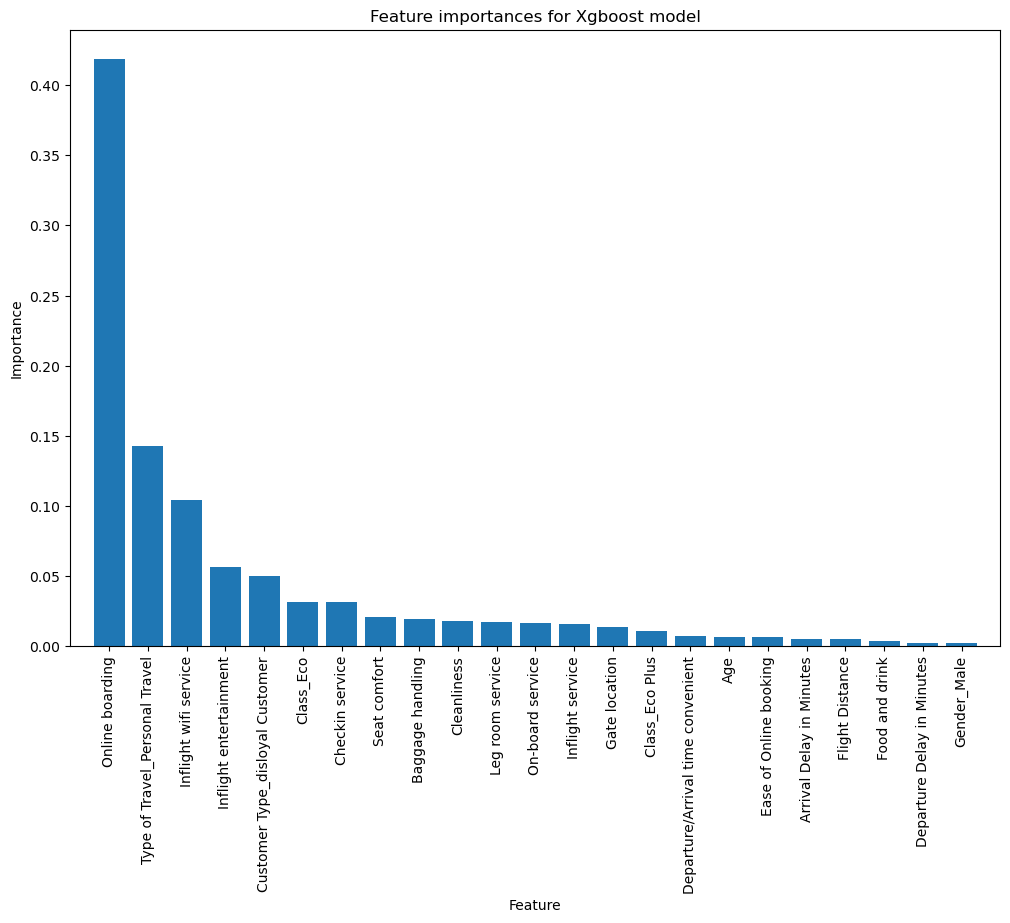

In [48]:
plt.figure(figsize=(6,6))
plt.title('Feature importances for Xgboost model')
plt.bar(range(X_train.shape[1]),importances[indices],align = 'center')
plt.xticks(range(X_train.shape[1]),feature_names[indices],rotation=90)
plt.xlim([-1,X_train.shape[1]])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

### XG boost model with top predictors

In [50]:
top_5_indices = indices[:5]
X_train_top5=X_train.iloc[:,top_5_indices]
X_test_top5=X_test.iloc[:,top_5_indices]

top_xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
top_xgb_clf.fit(X_train_top5, y_train)

y_train_pred_top_xgb = top_xgb_clf.predict(X_train_top5)
y_test_pred_top_xgb = top_xgb_clf.predict(X_test_top5)


print("Training Accuracy:", accuracy_score(y_train, y_train_pred_top_xgb))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred_top_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred_top_xgb))
print("Classification Report for  XGBoost with top predictors:\n",classification_report(y_test, y_test_pred_top_xgb))

Training Accuracy: 0.9293386202648599
Testing Accuracy: 0.9275485063135201

Confusion Matrix:
 [[13842   731]
 [ 1151 10252]]
Classification Report for  XGBoost with top predictors:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94     14573
           1       0.93      0.90      0.92     11403

    accuracy                           0.93     25976
   macro avg       0.93      0.92      0.93     25976
weighted avg       0.93      0.93      0.93     25976



### Partial Dependence Plots

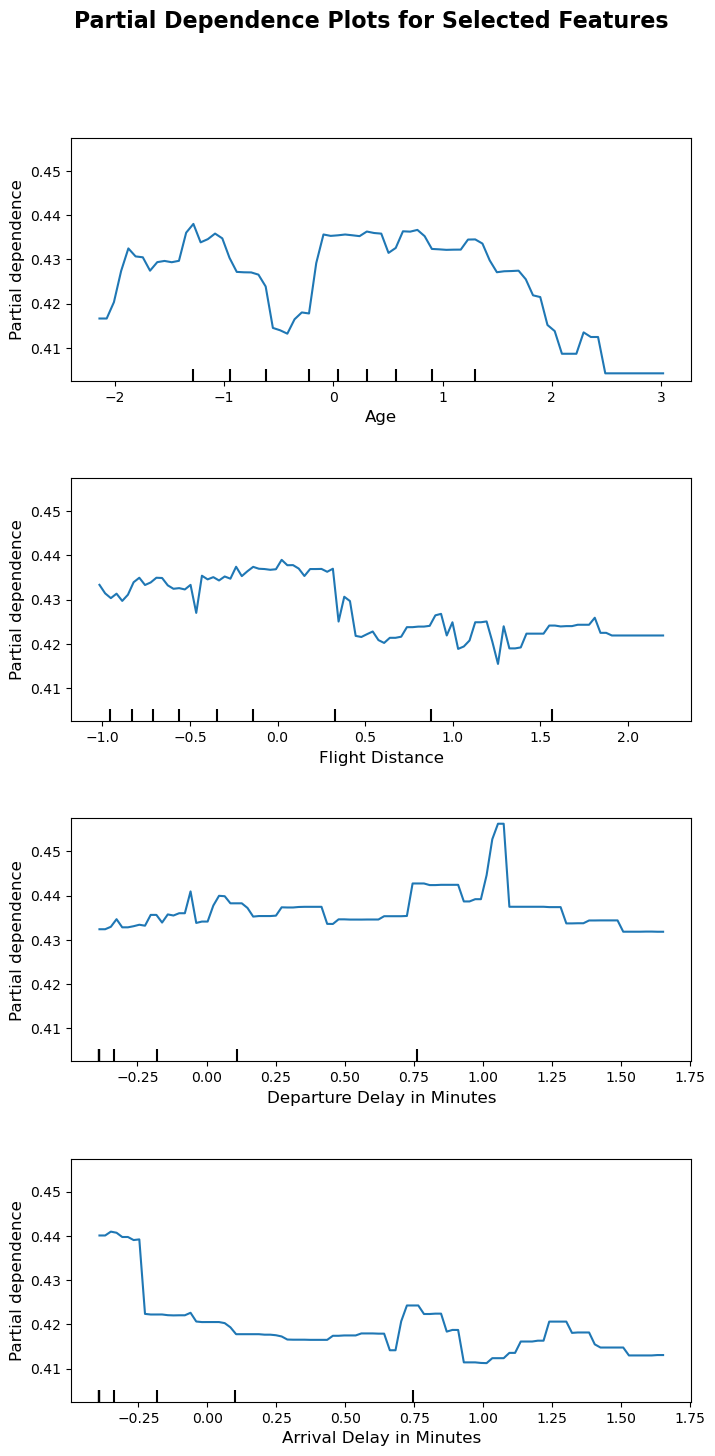

In [57]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Define the list of numerical features for which you want PDPs
numerical_features = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']  # Update these with your feature names

# Create a figure and subplots for each feature to ensure visual clarity
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(8, 4 * len(numerical_features)), dpi=100)

# Plot Partial Dependence Plots for each feature
display = PartialDependenceDisplay.from_estimator(
    xgb_clf,                    # Your trained XGBoost model
    X_train_scaled,             # Data the model was trained on
    features=numerical_features,# Features for which you want PDPs
    grid_resolution=100,        # Set resolution for smooth curves
    target=1,                   # Target class (1 for positive class in binary classification)
    ax=ax                       # Assign each plot to a subplot
)

# Set an overall title and adjust spacing for the plots
fig.suptitle("Partial Dependence Plots for Selected Features", fontsize=16, weight='bold')
plt.subplots_adjust(top=0.9, hspace=0.4)

# Enhance each subplot's visuals
for axis in ax:
    axis.title.set_fontsize(14)
    axis.title.set_fontweight('bold')
    axis.set_xlabel(axis.get_xlabel(), fontsize=12)
    axis.set_ylabel(axis.get_ylabel(), fontsize=12)

plt.show()